<a href="https://colab.research.google.com/github/vkn889/ai-powered-skin-cancer-detection/blob/main/mlCancerDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip -q install pyngrok > /dev/null
!pip -q install streamlit > /dev/null
!pip -q install patool > /dev/null

import cv2
import gdown
import glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import patoolib
import streamlit as st

from joblib import dump
from tqdm import tqdm
from pyngrok import ngrok

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.optimizers import SGD

# Set up data directory
DATA_ROOT = '/content'
os.makedirs(DATA_ROOT, exist_ok=True)
!unzip "skin_cancer.zip" > /dev/null

# Get image paths from your skin_cancer folder
benign_img_paths = glob.glob('/content/skin_cancer/benign/*.jpg')
malignant_img_paths = glob.glob('/content/skin_cancer/malignant/*.jpg')

print(f"Found {len(benign_img_paths)} benign images")
print(f"Found {len(malignant_img_paths)} malignant images")

# Balance classes by using minimum count or cap at 3000
samples_per_class = min(len(benign_img_paths), len(malignant_img_paths), 3000)
total_samples = 2 * samples_per_class

print(f"Using {samples_per_class} samples per class")

# Make X and y from data
X = []
y = []

for i in tqdm(range(samples_per_class)):
  img = cv2.imread(benign_img_paths[i])
  X.append(cv2.resize(img, (224,224))) # standardize image size
  y.append(0)

for i in tqdm(range(samples_per_class)):
  img = cv2.imread(malignant_img_paths[i])
  X.append(cv2.resize(img, (224,224)))  # 224x224 instead of 50x50
  y.append(1)

X = np.array(X)
y = np.array(y)

print("Created our X and y variables")

# Save some sample images for trying out Streamlit app
skin_samples_dir = 'skin_samples'
if (os.path.exists(skin_samples_dir) == False):
  os.mkdir(skin_samples_dir)

for i, img in enumerate(X[samples_per_class-5:samples_per_class]):
  plt.imsave(f'benign_test_img_{i}.jpg', img)

for i, img in enumerate(X[samples_per_class:samples_per_class+5]):
  plt.imsave(f'malignant_test_img_{i}.jpg', img)

# Helpful function for launching our Streamlit app
def launch_website():
  print ("Click this link to try your web app:")
  if (ngrok.get_tunnels() != None):
    ngrok.kill()
  tunnel = ngrok.connect()
  print(tunnel.public_url)
  !streamlit run --server.port 80 app.py > /dev/null



replace skin_cancer/benign/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: All
Found 1800 benign images
Found 1497 malignant images
Using 1497 samples per class


100%|██████████| 1497/1497 [00:01<00:00, 907.82it/s]


Created our X and y variables


Shape of X: (2994, 224, 224, 3)
Shape of y: (2994,)


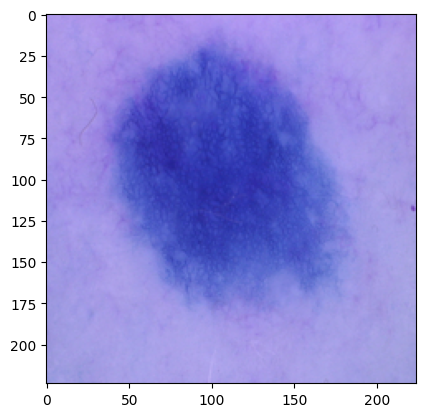

Label: 0


In [16]:
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
plt.imshow(X[0])
plt.show()
print(f"Label: {y[0]}")

Total elements: 450680832
Number of images: 2994
Pixels per image: 150528


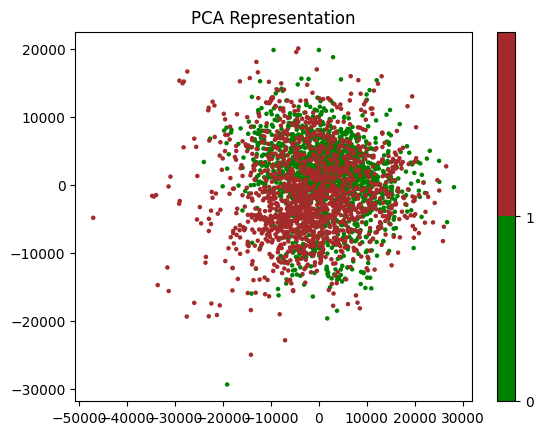

In [19]:
pca = PCA(n_components=20)

# Calculate the exact number automatically
total_elements = X.size  # Total elements in the array
num_images = X.shape[0]  # Number of images
pixels_per_image = total_elements // num_images  # Exact division

print(f"Total elements: {total_elements}")
print(f"Number of images: {num_images}")
print(f"Pixels per image: {pixels_per_image}")

X_pca = pca.fit_transform(np.reshape(X, (num_images, pixels_per_image)))

colors = ["green","brown"]
classes = [0,1]

plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap=matplotlib.colors.ListedColormap(colors), s=5)
cb = plt.colorbar()
loc = np.arange(0,max(y),max(y)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(classes)
plt.title("PCA Representation")
plt.show()

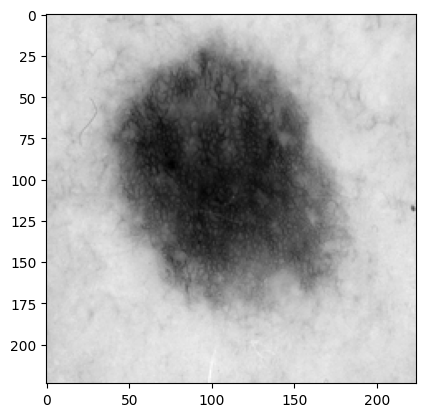

In [20]:
X_gray = []

for i in range(total_samples):
  X_gray.append(cv2.cvtColor(X[i], cv2.COLOR_RGB2GRAY))

X_gray = np.array(X_gray)

plt.imshow(X_gray[0], cmap='gray')

In [22]:
X_gray_flat = np.reshape(X, (X.shape[0], X.shape[1] * X.shape[2] * X.shape[3]))


In [ ]:
X_train_vgg, X_test_vgg, y_train_vgg, y_test_vgg = train_test_split(X, y, test_size=0.33, random_state=42)
# load the expert VGG16 network but do not include the final layers
vgg_expert = VGG16(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))

# we add the first 12 layers of VGG16 to our own model vgg_model
vgg_model = Sequential()
vgg_model.add(vgg_expert)

# and then add our own layers on top of it
vgg_model.add(GlobalAveragePooling2D())
vgg_model.add(Dense(1024, activation = 'relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(512, activation = 'relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(1, activation = 'sigmoid'))

vgg_model.compile(loss = 'binary_crossentropy',
          optimizer = SGD(learning_rate=1e-4, momentum=0.95),
          metrics=['accuracy'])

vgg_model.fit(X_train_vgg, y_train_vgg,
              batch_size=64,
              epochs=30,
              verbose=1,
              validation_data=(X_test_vgg, y_test_vgg),
              shuffle=True)

print("Accuracy: {}".format(vgg_model.evaluate(X_test_vgg, y_test_vgg)[1], verbose=0))

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.5747 - loss: 0.8573 - val_accuracy: 0.8170 - val_loss: 0.4678
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 68s 998ms/step - accuracy: 0.7799 - loss: 0.4908 - val_accuracy: 0.8251 - val_loss: 0.3845
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 988ms/step - accuracy: 0.8188 - loss: 0.4122 - val_accuracy: 0.8453 - val_loss: 0.3345
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 984ms/step - accuracy: 0.8420 - loss: 0.3579 - val_accuracy: 0.8281 - val_loss: 0.3493
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 999ms/step - accuracy: 0.8484 - loss: 0.3406 - val_accuracy: 0.8392 - val_loss: 0.3260
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8575 - loss: 0.3095 - val_accuracy: 0.8291 - val_loss: 0.3648
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8522 - loss: 0.3233 - val_accuracy: 0.8423 - val_loss: 0.3327
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 987ms/step - accuracy: 0.8356 - loss: 0.3267 - val_accuracy: 0.8

In [36]:
from joblib import dump, load
dump(vgg_model, 'vgg_model.joblib')
clf = load('vgg_model.joblib')

In [27]:
!ngrok authtoken 31QYayTXPbbkBji5LlVcqVvRxSe_6nfgdoVxDnrcFWBceLKFx

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [56]:
%%writefile app.py
import streamlit as st
from joblib import load
import numpy as np
import cv2

model = load("vgg_model.joblib")

st.title('Skin Cancer Detection')
uploaded_file = st.file_uploader("Upload Image")
if uploaded_file is not None:
    file_bytes = np.asarray(bytearray(uploaded_file.read()), dtype=np.uint8)
    image = cv2.imdecode(file_bytes, 1)

    # Display the image
    st.image(image, caption="Uploaded Image", use_column_width=True)

    # Resize to 224x224 (keep color channels)
    rescaled_img = cv2.resize(image, (224,224))

    # Normalize pixel values (if your model was trained with normalization)
    rescaled_img = rescaled_img.astype('float32') / 255.0

    # Add batch dimension: shape becomes (1, 224, 224, 3)
    model_input = np.expand_dims(rescaled_img, axis=0)

    # Make prediction
    prediction = model.predict(model_input)

    # Extract the actual prediction value
    pred_value = prediction[0][0]  # Get the first prediction, first value
    confidence = float(pred_value)  # Convert to Python float

    # Display result
    if confidence > 0.5:
        st.write("**Result: Malignant** ⚠️")
        confidence_pct = confidence * 100
        st.write(f"Confidence: {confidence_pct:.1f}%")
    else:
        st.write("**Result: Benign** ✅")
        confidence_pct = (1 - confidence) * 100
        st.write(f"Confidence: {confidence_pct:.1f}%")

Overwriting app.py


In [57]:
launch_website()

Click this link to try your web app:
https://7eb6cc44fa04.ngrok-free.app
2025-08-19 07:17:32.545130: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755587852.584709   24893 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755587852.596458   24893 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755587852.625114   24893 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755587852.625162   24893 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:17